# Lecture 4 - Basic Filtering

The most basic filtering operation is removal of noise.  A typical scenario is that there is an original signal $x$ which is perhaps a person singing.  We listen to the radio broadcast, where we hear $y=x+n$ where $n$ is noise added by the transmission process. The goal of a filter in the radio receiver is to reconstruct $\hat{x}$ from $y$ so that $\| \hat{x} - x \|$ is minimized.  

The noise may be independent of $x$ (as in added Gaussian white noise) or dependent on $x$ (if there is a predictable distortion), or it could be both.  An example of independent noise is hiss or hum due to electrical interference. An example of a predictable distortion might be a compression operation such as $y(t)=\sqrt{x(t)}$ that we need to undo using a (nonlinear) squaring operation $\hat{x}(t) = y(t)^2$.

In linear filtering, all we can do is to hope that $x$ and $n$ have different frequency spectra, so that we can remove $n$ by linear filtering.  For example, if $x$ is low-frequency and $n$ is high-frequency, then a low-pass filter will attenuate $n$ more than $x$.  This will not work when the noise depends on $x$, if the noise shares frequencies with $x$, or if there is a nonlinear distortion.  

The overall structure will be that we create a network $F$ to approximate the true input from the noisy data, so that $\hat{x} = F(y)$ where $y$ is the noisy or distorted data, and $\hat{x}$ is our estimate of the true signal $x$.  We can write $\hat{x} = F(N(x))$ to emphasize that in some sense the network $F$ is trying to be the inverse of the noise $N$.

In general, the noise may not be memoryless.  Memoryless means that $y(t) = N[x(t)]$ so each sample depends only on the input at that time.  But most distortion is not memoryless.  For instance, an echo might be $y(t) = x(t-t_{\rm echo})$ where $t_{\rm echo}$ is the echo time.  So the inputs to the network will generally be a series of lagged values $<y(t), y(t-1), \ldots y(t-T)>$. 

Note that although memoryless distortion (eg: $y(t)=\sqrt{x(t)}$) only requires a memoryless filter (eg: $\hat{x}(t) = y(t)^2$), memoryless noise (eg: $y(t) = x(t) + n(t)$) may require a filter with memory. This is true even for linear filters, because if we are removing high-frequency noise by low-pass filtering $y$, then we need lagged values to calculate the FIR or IIR filters.  The reason this is the case is that the only way to remove noise from a signal is to know something about the signal (otherwise how do you know the noise isn't part of the signal?).  For low-pass filtering, you know the signal is low frequency. For music, you know that western music tends to play on one of 12 notes in each octave.  For estimation of speed, you know that airplanes cannot change speed instantaneously.  So usually our knowledge of the signals we want to estimate includes something about their time-course, smoothness, patterns, or acceptable values over time. So a network could learn these patterns in order to discriminate signal from noise.

This is similar to the timeseries prediction we did in Lecture1, where you try to predict the next value in the series.  If we assume that noise is unpredictable, then the only thing that can be predicted must be signal.  If we assume that the predictor for the signal will be a poor predictor for the noise (because they do not look the same) then a predictor for the signal may ignore the noise.  On the other hand, if the noise is predictable (a motor, background music, etc.) then you can predict the noise and subtract it from the signal.




In [1]:
# Needed imports
import numpy as np
import pandas as pd
from IPython.display import Audio
from scipy.io import wavfile   # this is for playing audio
import matplotlib.pyplot as plt
import seaborn as sns

Create a simple sound as a combination of two sin waves.


In [2]:
# Create a sound
framerate = 44100
t = np.linspace(0,5,framerate*5)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)

In [3]:
# Generate a player for mono sound
#NOTE: do not put a semicolon after the Audio() call or you will not see the player.
Audio(data,rate=framerate)

For more complex sounds you will need to load a sound file.  WAV files are the easiest to work with.  Python, matlab, the Mac "Music" app, and many others can create wav files.  There are also some tools that will convert the more common mp3 format into wav. 

In [4]:
    # How to load a sound file from GitHub
    # Note that you need the link to the "raw" file on github or the file format will fail
    !wget https://github.com/R6500/Python-bits/raw/master/Colaboratory/Sounds/Bicycle%20bell%203.wav
    #the file will end up at the top level of the local (colab) directory
    !ls   
    data = wavfile.read('Bicycle bell 3.wav')
    Audio(data[1], rate=data[0])  #data[0] is the sample rate, data[1] is the (mono) data


Output hidden; open in https://colab.research.google.com to view.

In [5]:
#For your own files, it is easier to reaad them from your own google drive
# this will mount your google drive (after asking permission) with all your directories under the "drive" tab
# to see them, click on the small folder icon in the left margin of the jupyter notebook
# then look under the drive/MyDrive subdirectory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Download the BachDoubleViolinConcerto.wav file from canvas/files 
#   put this file into your goole drive in some subdirectory
#   for example, mine is in the directory "Colab Notebooks"
data = wavfile.read('/content/drive/MyDrive/Colab Notebooks/BachDoubleViolinConcerto.wav')



Once the file is saved in the **virtual machine**, it can be read on a numpy array and decoded as sound information

In [7]:
# for Mono recordings, data[0] is the sample rate and data[1] is the byte sequence of sound
framerate = data[0]
sounddata = data[1]
#create the timestamps
time      = np.arange(0,len(sounddata))/framerate

# Show information about the object
print('Sample rate:',framerate,'Hz')
print('Total time:',len(sounddata)/framerate,'s')

Sample rate: 22050 Hz
Total time: 236.7190022675737 s


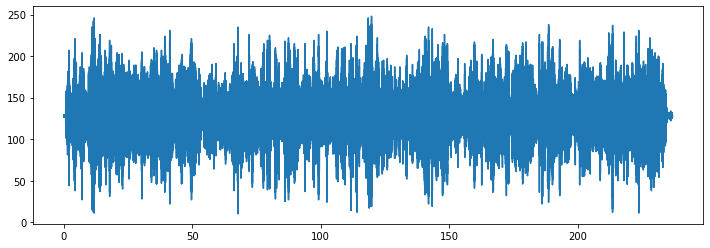

In [8]:
plt.figure(figsize=(12,4))
plt.plot(time, sounddata);

Surprisingly, Google Colab seems to have access to the speakers of your computer.  

In [9]:
#Play the sound
Audio(sounddata,rate=framerate)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
#get 3 second of data.  framerate is the number of samples in each second
start_data = 1*framerate
end_data = 4*framerate
x = sounddata[start_data:end_data]
t = time[start_data:end_data]
Audio(x, rate=framerate)

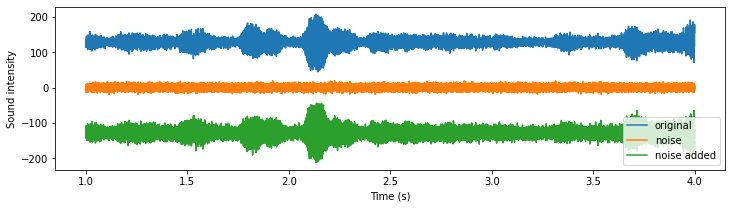

In [11]:
#additive random Gaussian noise y=x+n
from numpy.random import default_rng
rng = default_rng()

rms = np.sqrt(np.mean((x-np.mean(x))**2))  #find the signal power for scaling the noise
noise = rng.standard_normal(len(x))*rms*0.4   #noise is gaussian 40% of signal rms power
plt.figure(figsize = (12,3))
plt.plot(t,x, label='original')
plt.plot(t,noise, label='noise')
plt.plot(t,noise-x, label='noise added')
plt.xlabel('Time (s)')
plt.ylabel('Sound intensity')
plt.legend()

noise_data = x+noise
Audio(noise_data, rate=framerate)

#Filtering starts here
(so does the homework for the other two cases.  see below)

In [12]:
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [13]:
#create the series, dataframes, and training and validation sets
input_series = pd.Series(name='inputSeries', data=x, index = t)
input_frame = input_series.to_frame(name='inputSeries')
noise_series = pd.Series(name='noiseSeries', data=noise_data, index = t)
noise_frame = noise_series.to_frame(name='noiseSeries')

input_frame.describe()



,inputSeries
count,66150.000000
mean,128.002978
std,12.259544
min,44.000000
25%,122.000000
50%,128.000000
75%,135.000000
max,207.000000


In [14]:
#create the training and test sets
validation_size = np.int(0.1*len(x))
validation_start = len(x)-validation_size
xTrain = input_frame.iloc[:validation_start]
xTest = input_frame.iloc[validation_start:]
noiseTrain=noise_frame.iloc[:validation_start]
noiseTest = noise_frame.iloc[validation_start:]

#preprocessing; scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)  #converts to a numpy array
xTest = scaler.transform(xTest)
noiseTrain = scaler.transform(noiseTrain)
noiseTest = scaler.transform(noiseTest)

#create the data generators
#  note that the network input is the noisy signal, and the desired output is the clean signal
predict_length = np.int(0.005*framerate)  #5msec segments for prediction
pl2 = np.int(predict_length/2)  #used to offset the prediction to the middle of the sample

#the desired output is shifted pl2 to the right (by duplicating the first elements)
#  TimeSeriesGenerator always tries to predict the NEXT output after the end
#  By shifting pl2 to the right, we try to predict the MIDDLE output
#  This will be a non-causal filter (or a causal filter with a delay) but that's ok
trainGenerator = TimeseriesGenerator(noiseTrain, np.append(xTrain[:pl2],xTrain[:-pl2]), length=predict_length, batch_size=1)
validationGenerator = TimeseriesGenerator(noiseTest, np.append(xTest[:pl2],xTest[:-pl2]), length = predict_length, batch_size=1)
shortTrainGenerator = TimeseriesGenerator(noiseTrain[:1000], np.append(xTrain[:pl2],xTrain[:1000-pl2]), length=predict_length, batch_size=1)
shortValidationGenerator = TimeseriesGenerator(noiseTest[:1000], np.append(xTest[:pl2],xTest[:1000-pl2]), length = predict_length, batch_size=1)

#early stopping may not be needed, because the data length is so long we can use a small number of batches
early_stop = EarlyStopping(monitor='val_loss',patience=2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- noiseSeries
Feature names seen at fit time, yet now missing:
- inputSeries

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- noiseSeries
Feature names seen at fit time, yet now missing:
- inputSeries

  warnings.warn(message, FutureWarning)


In [15]:
#create the network
n_features = 1

#will use two nonlinear layers so that we can capture second-order interactions between inputs in the first layer
model = Sequential()
use_LSTM = 0
if use_LSTM ==1:   #LSTM creates a dynamic model of the signal
  model.add(LSTM(20,activation='sigmoid', input_shape = (predict_length, n_features)))
else:
  model.add(Flatten(input_shape = (predict_length, n_features)))
model.add(Dense(10, activation='sigmoid'))  #we expect the predictor will be a smoother, so use smooth activation
model.add(Dense(5, activation = 'sigmoid'))
model.add(Dense(1))  #this is a single output linear network at the top to allow scaling to the correct output range
model.compile(optimizer='adam', loss='mse')  #mse because is a regression problem
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 2,031
Trainable params: 2,031
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
890/890 [==============================] - 65s 73ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 2/3
890/890 [==============================] - 66s 74ms/step - loss: 0.0021 - val_loss: 0.0096
Epoch 3/3
890/890 [==============================] - 64s 72ms/step - loss: 0.0020 - val_loss: 0.0097


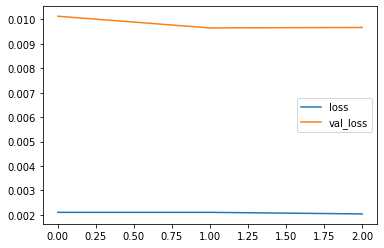

In [17]:
#train the model
# only need a few epochs because each one has much data (22k data points per second)
if use_LSTM ==1:
  model.fit(shortTrainGenerator,epochs=3,   #use the short version because training is slow
                    validation_data=shortValidationGenerator,
                   callbacks=[early_stop])
else:
  model.fit(trainGenerator,epochs=3,
                    validation_data=validationGenerator,
                   callbacks=[early_stop])
losses = pd.DataFrame(model.history.history)
losses.plot();

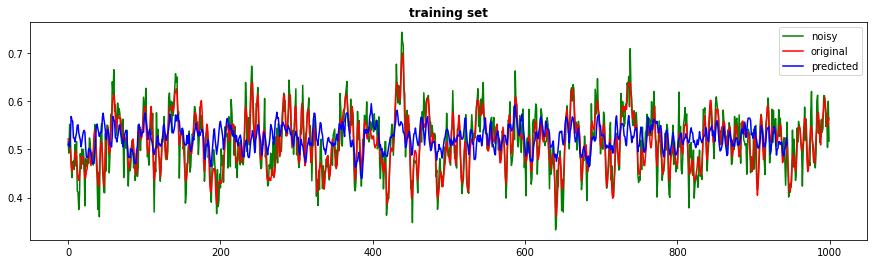

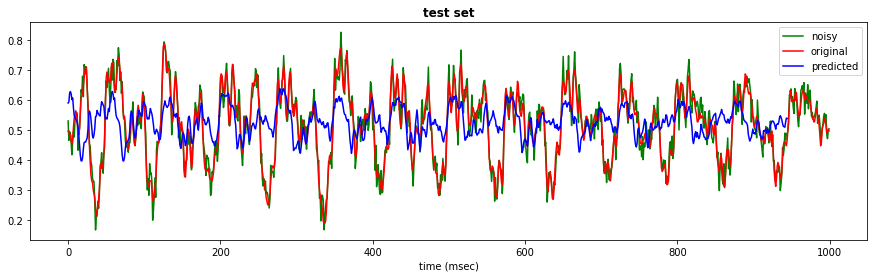

In [18]:
#compare the predicted timeseries
predicted_outputs = model.predict(shortTrainGenerator)   #use short versions to speed this up
predicted_validation = model.predict(shortValidationGenerator)

plt.figure(figsize=(15,4), linewidth = 1)
plt.plot(noiseTrain[:1000],'g',label='noisy')  #input to the network
plt.plot(xTrain[:1000],'r',label='original')    #target output of the network (the clean signal)
#the network prediction is offset to the end of the segment; duplicate the first pl2 to fix the alignment
plt.plot(np.append(predicted_outputs[:pl2], predicted_outputs[:1000-pl2]),'b', label='predicted')
plt.title('training set',fontweight="bold")
plt.legend()

plt.figure(figsize=(15,4), linewidth = 1)
plt.plot(noiseTest[:1000],'g',label='noisy')
plt.plot(xTest[:1000],'r',label='original')
#the network prediction is offset to the end of the segment; duplicate the first pl2 to fix the alignment
plt.plot(np.append(predicted_validation[:pl2], predicted_validation[:1000-pl2]),'b', label='predicted')
plt.title('test set',fontweight="bold");
plt.xlabel('time (msec)')
plt.legend();



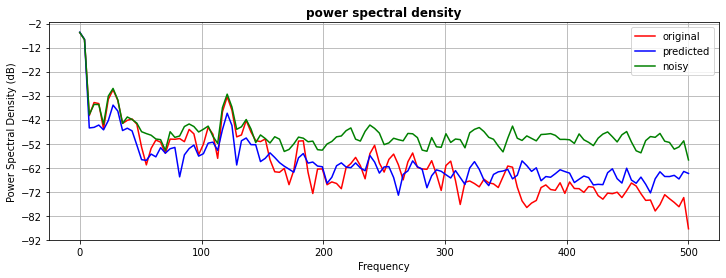

In [19]:
#compare the power spectral densities
plt.figure(figsize=(12,4))
plt.psd(xTrain.ravel()[:1000], color='r', Fs=1000, scale_by_freq=0, label='original');
plt.psd(predicted_outputs.ravel()[:1000], Fs=1000, color = 'b', scale_by_freq=0, label='predicted');  #use ravel to make a horizontal array
plt.psd(noiseTrain.ravel()[:1000], Fs=1000, color = 'g', scale_by_freq=0, label='noisy');  #use ravel to make a horizontal array
plt.title('power spectral density',fontweight="bold");
plt.legend();

In [20]:
#listen to a longer segment after filtering
predicted_music = model.predict(trainGenerator)
Audio(predicted_music.ravel(), rate=framerate)


In [21]:
#here is the original (noisy) segment for comparison
Audio(noise_data, rate=framerate)

For homework problem 1: echo_data

In [ ]:
#echo of same signal slightly delayed
echo_length = np.int(0.2*framerate)
echo = sounddata[start_data-echo_length:end_data-echo_length]

echo_data = x + np.multiply(1.0, echo)
Audio(echo_data, rate=framerate)

For homework problem 2: mixture_data

In [ ]:
#mixture of two similar signals
source2_offset = 40*framerate  #data from 40 seconds in the future
source2 = sounddata[start_data+source2_offset:end_data+source2_offset]

delayed_source2 = np.append(source2[0:3], source2[:-3])  #delays by 3 steps
mixture_data = x + delayed_source2**3 * np.std(x)/np.std(delayed_source2**3)
Audio(mixture_data, rate=framerate)

#Homework #3

1. Repeat the network filtering process for echo_data.  You may have to adjust the network structure, predict_length, number of epochs, or earlystopping criteria to make it work.

2. Do headphone noise-cancellation for the mixture_data.  The desired headphone output x is being mixed with an annoyance signal (source2) that is coming from outside the headphones (someone else playing music nearby).  The mixing is nonlinear (cubic) and includes a short delay, perhaps due to source2 being transmitted through the physical headphones.  Assume you have a microphone inside the headphones so that know mixture_data and you have a microphone outside the headphones so that you know source2.  What you don't know is how much of source2 gets inside the headphones, and how distorted it is.  
Your job is to remove source2 from mixture_data in order to recover the original signal and cancel the outside noise.  Therefore you want a network that tries its best to predict mixture_data from source2.  The network will essentially learn the delay and the cubic nonlinearity.  Once the network is trained, you can subtract its prediction from mixture_data in order to approximate the original data x.

In other words, your network $F$ is trained so that $mixture\_data \approx F(source2)$. Then you will do the noise cancellation by subtracting the noise estimate $\hat{x} = mixture\_data - F(source2)$, and comparing this to the original data $x$.